# Code Lab 3: Image Classification

## 1. Data Preparation

#### Part A: Load the Data into Python

The labels for each image are stored in a MatLab file (`imagelabels.mat`) and the images are provided to you in the folder `102flowers`. To begin, your first task will be to load everything into Python!

Objective 1:

* Get a list of all the labels
* Get a list of all the images
* Check that the length of both lists are the same!

Hint: look at the imports!

Note that not everything returned by loadmat(...) is useful, as the returned dictionary even contains certain metadata about the file. You should just pick out what you want, which in this case, is the array of labels.

In [1]:
import numpy as np
from scipy.io import loadmat

# Objective 1:
# Load labels from .mat (MatLab) file into a Python list
# Hint: always look at the imports given to you!

# answer
labels = loadmat("./imagelabels.mat")["labels"][0]
print(labels)
# end answer

[77 77 77 ... 62 62 62]


Run the code block below to check if you've made any error. If you get an AssertionError, it's most likely you've forgotten that __we want the labels to be a list, not a list of lists__. If the code runs without any error, move on. :)

In [2]:
assert len(labels) == 8189

In [3]:
import keras
from keras.utils import get_file

# download the dataset

DATASET_URL = "https://s3-ap-southeast-1.amazonaws.com/deeplearning-iap-material/102flowers.zip"
DATASET_DIR = keras.utils.get_file("102flowers.zip", DATASET_URL, cache_subdir='datasets', extract=True)
DATASET_DIR = DATASET_DIR.replace(".zip","")+"/102flowers"
print("Dataset downloaded to:", DATASET_DIR)

Using TensorFlow backend.


Dataset downloaded to: /home/jovyan/.keras/datasets/102flowers/102flowers


In [4]:
# find the bunch of jpgs!
!ls /home/jovyan/.keras/datasets/102flowers/102flowers

image_00001.jpg  image_02049.jpg  image_04097.jpg  image_06145.jpg
image_00002.jpg  image_02050.jpg  image_04098.jpg  image_06146.jpg
image_00003.jpg  image_02051.jpg  image_04099.jpg  image_06147.jpg
image_00004.jpg  image_02052.jpg  image_04100.jpg  image_06148.jpg
image_00005.jpg  image_02053.jpg  image_04101.jpg  image_06149.jpg
image_00006.jpg  image_02054.jpg  image_04102.jpg  image_06150.jpg
image_00007.jpg  image_02055.jpg  image_04103.jpg  image_06151.jpg
image_00008.jpg  image_02056.jpg  image_04104.jpg  image_06152.jpg
image_00009.jpg  image_02057.jpg  image_04105.jpg  image_06153.jpg
image_00010.jpg  image_02058.jpg  image_04106.jpg  image_06154.jpg
image_00011.jpg  image_02059.jpg  image_04107.jpg  image_06155.jpg
image_00012.jpg  image_02060.jpg  image_04108.jpg  image_06156.jpg
image_00013.jpg  image_02061.jpg  image_04109.jpg  image_06157.jpg
image_00014.jpg  image_02062.jpg  image_04110.jpg  image_06158.jpg
image_00015.jpg  image_02063.jpg  image_04111.jpg  image_06159

In [5]:
# Confirm the directory where the images are found
DATASET_DIR = "/home/jovyan/.keras/datasets/102flowers/102flowers"

Here, we'll be using glob, which is a library that helps us look for pathnames that match a certain pattern that you specify. Take a minute to refer to the [documentation here](https://docs.python.org/2/library/glob.html) to familiarise yourself with glob. We'll be using it quite a bit in our codelabs.

In [6]:
import glob

# Objective 1:
# Get a list of images in the folder "102flowers"

# answer
image_paths = glob.glob(DATASET_DIR+"/*.jpg")
image_paths.sort()
# end answer

# check answer
print("Path to first image:", image_paths[0]) # ./102flowers/image_00001.jpg
print("Path to last image:", image_paths[-1]) # ./102flowers/image_08189.jpg

Path to first image: /home/jovyan/.keras/datasets/102flowers/102flowers/image_00001.jpg
Path to last image: /home/jovyan/.keras/datasets/102flowers/102flowers/image_08189.jpg


Expected Output

```
Path to first image: /home/jovyan/.keras/datasets/102flowers/102flowers/image_00001.jpg
Path to last image: /home/jovyan/.keras/datasets/102flowers/102flowers/image_08189.jpg
```

In [7]:
# check that number of images and labels correspond
# Hint: use assert

# answer
assert len(image_paths) == len(labels)
# end answer

#### Part B: Create train-val split

We need to split our image dataset into a training and a validations set. Ideally, there should be a third test set. However, we are not going to do that today in the interest of keeping the Code Lab more streamlined. 

Note: depending on the library, words like "test", "validation" and "evaluation" may be interchangable.

Objective 2:

* split the images into 70% training and 30% validation set
  
  (hint: `test_size=0.3`)
  
You may find [this documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) useful.

In [8]:
from sklearn.model_selection import train_test_split

# Objective 2:

# answer
images_train, images_val = train_test_split(image_paths, test_size=0.3)
# end answer

total_train = len(images_train)
total_val = len(images_val)

print("Training set:", total_train)
print("Validation set:", total_val)

Training set: 5732
Validation set: 2457


In [9]:
# run this cell to check your percentage of validation data
print("Percent validation data", round(total_val/(total_train+total_val)*100,1))

Percent validation data 30.0


#### Part C: Pre-process and organise into folders (important for keras data_generator!)

Objective 3:

* preprocess the images by resizing (our CNN will take in images that are 299 &times; 299).

  For this, make use of the provided `resize_and_pad` function to complete the `preprocess_image` function. We will again use `preprocess_image` later in the Code Lab.


* The padding for the image can be a colour of your choosing (default is black == 0)

In [10]:
# helper code

import os
import cv2
from tqdm import tqdm_notebook

def make_folder(path):
    """
    Create a directory (folder) unless it already exists.
    """
    os.makedirs(path, exist_ok=True)
    
def resize_and_pad(img, size, pad_colour=0):
    """
    Resizes image, maintaining aspect ratio and filling in the excess areas with pad_colour
    """
    h, w = img.shape[:2]
    sh, sw = size
    # interpolation method
    if h > sh or w > sw:
        # shrinking image
        interp = cv2.INTER_AREA
    else:
        # stretching image
        interp = cv2.INTER_CUBIC

    aspect = w/h

    if aspect > 1:
        # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1:
        # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else:
        # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    if len(img.shape) is 3 and not isinstance(pad_colour, (list, tuple, np.ndarray)):
        # color image but only one color provided
        pad_colour = [pad_colour]*3

    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right,
                                    borderType=cv2.BORDER_CONSTANT, value=pad_colour)

    return scaled_img

In [11]:
def preprocess_image(image):
    # Objective 3:
    # Resize and pad the images
    
    # answer
    processed_image = resize_and_pad(image, (299,299), 0)
    # end answer
    
    return processed_image

We will now begin preprocessing and writing our training/validation images into folders, where every folder will contain images of the certain class. We use the `tqdm` module to show our progress in a nice way. In the interest of time, we will ignore all classes above a certain number (index). This is set using the `IGNORE_ABOVE` variable below.

In [12]:
IGNORE_ABOVE = 10

In [13]:
! rm -r ./train ./val

In [14]:
TRAIN_DATA_DIR = "./train/"

for image_path in tqdm_notebook(images_train):
    try:
        # get image index
        image_index = int(image_path.split("_")[1].replace(".jpg",""))
        # get class index
        class_index = labels[image_index-1]
        
        if int(class_index)>IGNORE_ABOVE:
            pass
        else:
            class_folder = TRAIN_DATA_DIR+str(class_index)+"/"

            image = cv2.imread(image_path)
            image = preprocess_image(image)

            # make class folder
            make_folder(class_folder)

            # make image output path and write image
            image_output_path = class_folder+str(image_index)+".jpg"

            cv2.imwrite(image_output_path, image)
    except Exception as e:
        print(image_path, e)

In [15]:
VAL_DATA_DIR = "./val/"

for image_path in tqdm_notebook(images_val):
    try:
        # get image index
        image_index = int(image_path.split("_")[1].replace(".jpg",""))
        # get class index
        class_index = labels[image_index-1]
        if int(class_index)>IGNORE_ABOVE:
            pass
        else:
            class_folder = VAL_DATA_DIR+str(class_index)+"/"

            image = cv2.imread(image_path)
            image = preprocess_image(image)

            # make class folder
            make_folder(class_folder)

            # make image output path and write image
            image_output_path = class_folder+str(image_index)+".jpg"

            cv2.imwrite(image_output_path, image)
    except Exception as e:
        print(image_path, e)

#### Part D: Sanity check!

Let's check our directories and images and see if they turn out the way we expect.

**Important**:  pay attention to check out how the folders are ordered...

In [16]:
print("train folder contains:")
!ls train
print("\ntrain/1 folder contains:")
!ls train/1

print("\nval folder contains:")
!ls val
print("\nval/1 folder contains:")
!ls val/1

train folder contains:
1  10  2  3  4	5  6  7  8  9

train/1 folder contains:
6734.jpg  6740.jpg  6745.jpg  6751.jpg	6756.jpg  6761.jpg  6767.jpg  6771.jpg
6735.jpg  6741.jpg  6746.jpg  6752.jpg	6757.jpg  6762.jpg  6768.jpg  6772.jpg
6738.jpg  6742.jpg  6748.jpg  6753.jpg	6759.jpg  6763.jpg  6769.jpg  6773.jpg
6739.jpg  6744.jpg  6749.jpg  6754.jpg	6760.jpg  6765.jpg  6770.jpg

val folder contains:
1  10  2  3  4	5  6  7  8  9

val/1 folder contains:
6736.jpg  6743.jpg  6750.jpg  6758.jpg	6766.jpg
6737.jpg  6747.jpg  6755.jpg  6764.jpg


**Displaying an image**

Now, we want to load an image to check if our preprocessing is appropriate. OpenCV loads images in BGR, while matplotlib uses RGB. Hence, we need to correct the **colour space** of the image if we want to see it properly in matplotlib.

Documentation: https://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html

./val/8/3318.jpg


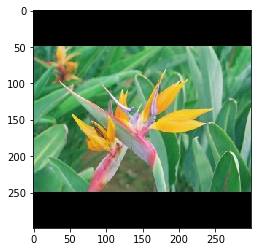

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

print(image_output_path)

image = cv2.imread(image_output_path) # let's load the last image we wrote

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

## 2. Keras Model

Now, we will build our input pipeline, the Keras model and then begin our training.

In [18]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model, load_model
from keras.layers import *
from keras import backend as K
from keras import optimizers, callbacks, regularizers
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import preprocess_input

# some parameters we want to decide beforehand

BATCH_SIZE = 64
INPUT_SIZE = (299,299)
NUM_CLASS = len(glob.glob("./val/*"))
print("Number of classes:", NUM_CLASS)

Number of classes: 10


#### Part A: Input Pipeline

We will create our ImageDataGenerator here. Keras's ImageDataGenerator allows us to _perform data augmentation on-the-fly_, and allows us to use the very useful __fit_generator__ function later on when training. 

Note that the ImageDataGenerator __automatically infers the number of classes you have based on your directory structure__ i.e. If you have 3 folders, Keras will naturally assume that each folder is a separate class by itself, and the images within the folder are images specific to that class.

You can perform the data augmentations by specifying the arguments in the ImageDataGenerator. You can look up the available augmentations here: https://keras.io/preprocessing/image/ .There are really no hard-and-fast rules to what sort of augmentations you can or should apply, so it's a matter of testing to see which ones work best for your task at hand.

Finally, we create separate ImageDataGenerators for our train, validation, and test datasets. In this case, we only have a train and validation dataset, so we'll only be creating two IDGs. Note that we need not apply the same augmentation to both the training and validation dataset.

In [19]:
print("Creating Train Data Generator")
train_datagen = ImageDataGenerator(rotation_range=90,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory('./train/',
                                                    target_size=INPUT_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

print("\nCreating Validation Data Generator")
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory('./val/',
                                                              target_size=INPUT_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical')

Creating Train Data Generator
Found 371 images belonging to 10 classes.

Creating Validation Data Generator
Found 151 images belonging to 10 classes.


##### Part B: Build the model

We are using transfer learning by applying a pre-trained [Xception (Chollet, 2017)](https://arxiv.org/abs/1610.02357) CNN and fine-tuning a final classification layer. If you want, you can also try using a pre-trained ResNet50 instead, and see which model performs better.

To build the model, we will be using the [Keras Model (Functional) API](https://keras.io/getting-started/functional-api-guide/). This API gives us flexibility and allows us to specify how we want the tensors to flow through our model. To do this, we need to do 4 things.
1. Specify your Input tensor
2. Instantiate your base model (Xception or ResNet50)
3. Add the last few layers to suit your classification task
4. Instantiate your Model instance and compile it

***
__Step 1__  
In the first step, we need to specify the very first input tensor for Keras, and then Keras will automatically infer the subsequent tensor shapes for us, so we don't need to bother about keeping track of the changes in tensor shapes after the first layer. We specify the input tensor by passing the input shape as arguments as such: Input(_width_, _height_, _depth_). Hence, if your images are of size 50 x 50 x 3 for example, you would specify Input(shape=(50,50,3)).

Those of you who are sharp might notice that since we are sending in batches of data, the input shape should actually be a 4D tensor i.e. (batches, width, height, depth), and yet we are only specifying 3 arguments. This is because the Model API has been designed such that we _do not_ specify the batch size when passing the arguments in Input. Keras will figure that out by itself.

In [20]:
input_tensor = Input(shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3)) # input image

__Step 2__  
In the second step, we need to instantiate our base model. For this, you can choose to use either Xception or ResNet50. Xception is a newer model developed by the creator of Keras himself, Francois Chollet. However, in practice ResNet is the more popular and widely-used model. It is used as the model backbone to architectures like Mask RCNN, which is used in object detection tasks.

Check that you've imported Xception (or ResNet50) from `keras.applications.xception` (or `keras.applications.resnet50`). You should have done so among the other import statements in one of the code blocks above. Now, in order to instantiate your base model, you will need to specify 3 arguments:
1. input_tensor
2. weights
3. include_top

Refer to the documentation [here](https://keras.io/applications/#xception) to get clues on what the arguments should be. (Hints: Remember that we are applying __transfer learning__ - refer to the slides if you've forgotten what needs to be done to apply transfer learning properly). Note that if this is the first time you are downloading the base model, it might take some time to download.

In [21]:
print("Building base model for Xception...")

# start answer
# base = Xception(...)
base = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)
# end answer

print("Done!")

# You can also use ResNet50.
# If you wish to do so, comment out the 3 lines above and carry on 
# with the helper code below.

"""
print("Building base model for Resnet50...")
base = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
print("Done!")
"""

Building base model for Xception...
Done!


'\nprint("Building base model for Resnet50...")\nbase = ResNet50(input_tensor=input_tensor, weights=\'imagenet\', include_top=False)\nprint("Done!")\n'

__Step 3__  
Next, we need to add in our own layers to the base model to suit our task at hand. To do this, you must understand how the Model(Functional) API works, and you will need to be familiar with Keras layers. Take a few minutes to read the documentation [here](https://keras.io/getting-started/functional-api-guide/#all-models-are-callable-just-like-layers), and [here](https://keras.io/layers/core/).

In Keras, all models are made up of layers. The layers in Keras are objects that perform mathematical operations  that should be familiar to you by now. For instance, the Conv2D layer performs convolutions. The Pooling2D layer performs pooling. The Dense layer is a fully-connected layer, which performs matrix multiplcations followed by an activation function. These layers are configurable by passing arguments. For instance, Dense(64, activation='relu') creates a fully-connected layer with 64 neurons, with a ReLU activation function.

In the Model(Functional) API, __every layer is callable on a tensor and returns a tensor__. In other words, `y = Dense(...)(x)` is basically putting an input tensor called 'x' through a Dense layer, and then returning an output tensor called 'y'. 'y' can then be used as an input tensor into another layer. For convenience, we typically just use `x = Layer(..)(x)` for all the layers except the last layer since we don't really care about the tensors in between.

To do this step, you'll need to add at least 4 new layers in sequential order. 

1. a pooling layer of your choosing, 
2. a dense layer, 
3. a dropout layer, and then another 
4. dense layer.

Note that since we are adding these layers after the base model, we will need to access the tensors coming out of the base model and use them as inputs to the first of these 4 layers. __base.output equals to the output tensor coming out of the base model__.

It is up to you to specify the arguments of the 4 layers - but bear a few things in mind. For pooling, at the last few layers of a CNN, we don't often use anything larger than 2x2, and usually without any stride as well. For dense layer, the number of units will determine the shape of the output tensor. As an example, passing in a tensor with shape (batch_size, input_dim) will produce an output tensor of shape (batch_size, num_units). For dropout, anything less than 0.7 is fine.  

__You'll need to be especially careful about the last Dense layer__ - think carefully about what the output of the entire CNN should be in this case. (Hint: The output of a CNN should be a probability distribution over the number of classes)

In [22]:
features = GlobalAveragePooling2D()(base.output)
x = Dense(NUM_CLASS*2, activation='relu')(features)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASS, activation='softmax')(x)

Next, we will need to freeze the weights of the base model since they have already been pre-trained. This can be done easily by doing a for loop over the base layers, and setting layer.trainable to False.

In [23]:
# perhaps in the future, we can set some layers to trainable!

for layer in base.layers:
    layer.trainable = False

__Step 4__  
Last but not least. we will need to instantiate the model, and compile it. We instantiate the model by specifying the named tensors which will be its input and output. 

Compiling the model is also easy - it takes just one line of code. You'll need to specify the loss function, the optimizer and the metrics to track while training the model.   

- For the loss function, note that we are doing a __multi-class classification problem__ (as opposed to a binary classification problem such as classifying if an image is a dog or a cat).

- For the optimizer, you can take your pick among the optimizers listed [here](https://keras.io/optimizers/) in the Keras documentation, but we recommend using Adam. You may stick to the default values for the parameters in the optimizer, but feel free to tune them and watch what happens to your training time, model accuracy, etc.

- Finally, for metrics, we typically track accuracy (_note that metrics argument is expecting a list_)

In [24]:
model = Model(inputs=input_tensor, outputs=predictions)

In [25]:
model.compile(loss='categorical_crossentropy', # choose a loss function!!
              optimizer="adam",
              metrics=['acc'])

# Uncomment to take a look at your model!
#model.summary()

#### Part C: Training

Alright! Now you have everything ready to train the model! To do this, we'll be using the `fit_generator` function.


First, let's just instantiate `callbacks_list` as an empty list. You don't need to worry about callbacks for now. We'll be passing this empty list as an argument later on to our fit_generator. Typically, we should specify particular callbacks rather than an empty list, but for simplicity sake we won't be 
doing so here. If you're interested though, you may want to refer to the [Keras documentation on callbacks](https://keras.io/callbacks/).

In [26]:
callbacks_list = [] 

In [27]:
# example of some useful callbacks

from keras import callbacks

tb = callbacks.TensorBoard(log_dir='./logs',write_graph=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

callbacks_list = [tb, reduce_lr]

In [28]:
# This is just to get the size of our training and validation dataset. 
total_train = len(glob.glob("./train/*/*.jpg"))
total_val = len(glob.glob("./val/*/*.jpg"))

To know what arguments to specify in `fit_generator`, refer to the Keras documentation [here](https://keras.io/models/sequential/). Note that you can stick to most of the default arguments. Just remember that 

- The number of steps per epoch is equal to the dataset (floor) divided by the batch size
- You want to make use of your validation data generator
- Specify at least 20 epochs (we recommend 25, but it's up to you if you want to train for more epochs if you're willing to wait it out)

In [29]:
steps_train = int(total_train/BATCH_SIZE)
steps_val = int(total_val/BATCH_SIZE)

NUM_THREADS = 1 # set to number of cores allocated to you

print("Training Progress:")
model_log = model.fit_generator(train_generator, validation_data=validation_generator,
                                epochs=20, workers=NUM_THREADS, use_multiprocessing=False,
                                steps_per_epoch=steps_train, validation_steps=steps_val,
                                callbacks=callbacks_list)

Training Progress:
Epoch 1/20
5/5 [==============================] - 6s 1s/step - loss: 2.2695 - acc: 0.1500 - val_loss: 2.1327 - val_acc: 0.3047
Epoch 2/20
5/5 [==============================] - 4s 822ms/step - loss: 2.1122 - acc: 0.2760 - val_loss: 1.9700 - val_acc: 0.4828
Epoch 3/20
5/5 [==============================] - 4s 835ms/step - loss: 1.8965 - acc: 0.3417 - val_loss: 1.8541 - val_acc: 0.4943
Epoch 4/20
5/5 [==============================] - 5s 924ms/step - loss: 1.6898 - acc: 0.4469 - val_loss: 1.6840 - val_acc: 0.5469
Epoch 5/20
5/5 [==============================] - 4s 838ms/step - loss: 1.5934 - acc: 0.4948 - val_loss: 1.5554 - val_acc: 0.6092
Epoch 6/20
5/5 [==============================] - 4s 868ms/step - loss: 1.5525 - acc: 0.4696 - val_loss: 1.5727 - val_acc: 0.5172
Epoch 7/20
5/5 [==============================] - 5s 979ms/step - loss: 1.4424 - acc: 0.5563 - val_loss: 1.4454 - val_acc: 0.6328
Epoch 8/20
5/5 [==============================] - 4s 843ms/step - loss: 1.

#### Training Plot

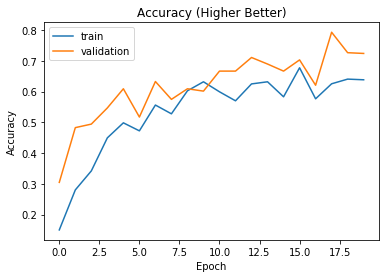

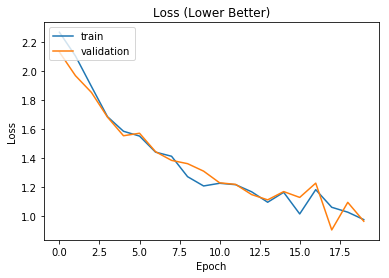

In [30]:
# Helper code to help you plot the training curves
plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('Accuracy (Higher Better)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss (Lower Better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 3. Evaluation

A model is not useful unless we can measure how well it performs.

In [31]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# learn more about sklearn.metrics:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Remember how the folders were ordered when you `ls`? Now we need to fix the class indexes. Print `name_id_map` if you don't understand why the ordering is messed up.

In [32]:
# Reads all the folders in which images are present
class_names = glob.glob("./val/*")
class_names = sorted(class_names) # Sorting them
fixed_classes = []
for class_name in class_names:
    fixed_classes.append(class_name.split("/")[-1])
name_id_map = dict(zip(range(len(class_names)), fixed_classes))

In [33]:
test_image_paths = glob.glob('./val/*/*.jpg')
print("Example image path:", test_image_paths[0])

Example image path: ./val/1/6736.jpg


Here you can take a look at the accuracy score for the model. That is, how many images it classified correctly over the total number of images. Note a few things:

- You want to apply the same preprocessing that you did earlier in order to be consistent
- You can simply use the `model.predict(...)` function in order to pass an image through the model and get an output
- The output of predict is a probability distribution over the classes. In order to know which class is actually predicted, you might find [np.argmax(...)](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.argmax.html) useful


In [34]:
test_ground_truth = [image_path.split("/")[-2] for image_path in test_image_paths]
test_preds = []

for image_path in tqdm_notebook(test_image_paths):
    image = cv2.imread(image_path)
    image = preprocess_image(image)
    image = image.reshape((1,299,299,3)) * (1./127.5) - 1
    preds = model.predict(image)
    output_pred = name_id_map[np.argmax(preds,axis=1)[0]]
    test_preds.append(output_pred)
    
print("Accuracy:", accuracy_score(test_ground_truth, test_preds))


Accuracy: 0.7152317880794702


In [35]:
print("Classification Report")
print(classification_report(test_ground_truth, test_preds))

Classification Report
              precision    recall  f1-score   support

           1       0.80      0.89      0.84         9
          10       1.00      1.00      1.00        14
           2       0.67      1.00      0.80        18
           3       0.00      0.00      0.00        16
           4       0.45      0.76      0.57        17
           5       0.68      1.00      0.81        17
           6       0.50      0.86      0.63         7
           7       1.00      0.20      0.33        15
           8       0.93      1.00      0.97        28
           9       1.00      0.10      0.18        10

   micro avg       0.72      0.72      0.72       151
   macro avg       0.70      0.68      0.61       151
weighted avg       0.71      0.72      0.65       151



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
cnf_matrix = confusion_matrix(test_ground_truth, test_preds)

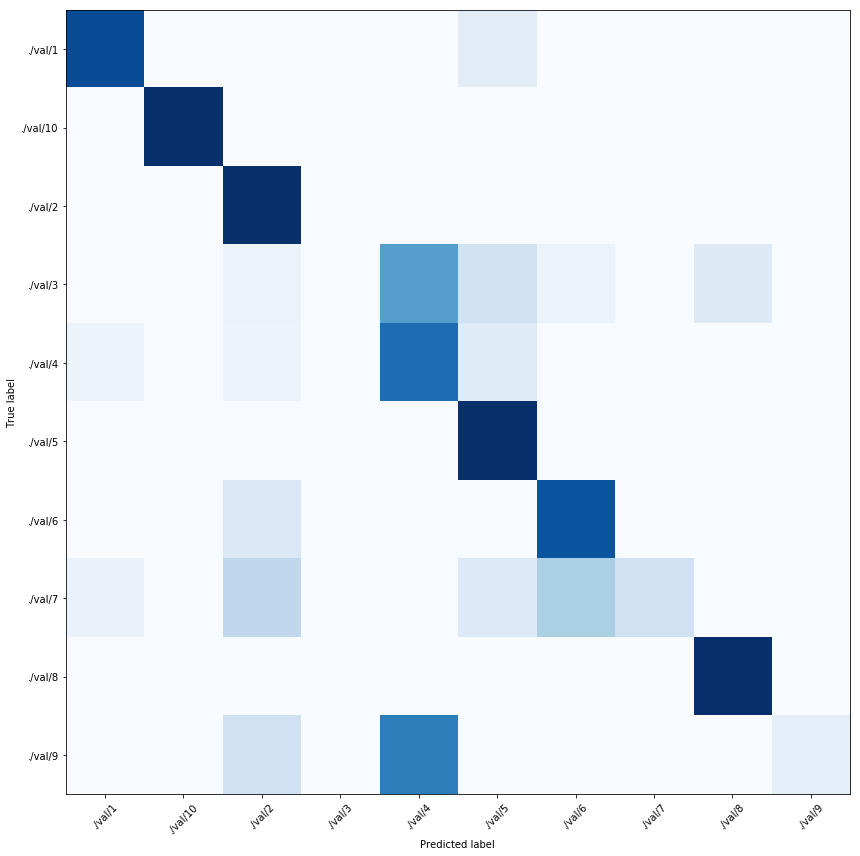

In [37]:
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

# You made it!

In this code lab, you learned how to:

* load a "large" image dataset
* preprocess and organise your dataset for Keras data_generator
* use data_generator with image augmentation
* train with fit_generator and fix the class indexes
* use transfer learning with a pre-trained CNN
* evaluate the performance of your model
